#LLM Authorship Attribution (JavaScript) - 5-class BERT training (A100 google colab optimized)

This Google Colab contains the code associated with the paper **The Hidden DNA of LLM-Generated JavaScript: Structural Patterns Enable High-Accuracy Authorship Attribution**, accepted at the 3rd International Workshop on Large Language Models for Code (LLM4Code ’26).

**Description:** This script is designed to train a BERT model for evaluating LLM authorship attribution. This Colab notebook walks through all the required steps to train BERT to identify which LLM generated a given JavaScript code snippet. In this example we train a BERt to distinguish the following GPT model families: gpt-4o, gpt-4o-mini, gpt-5-mini, gpt-5-nano, and gpt-oss-120b (five-class classification problem) .
In this setup, the training and test datasets are split by prompts, ensuring there is no overlap between them. As a result, the model is evaluated on entirely unseen JavaScript code, providing a more rigorous assessment of its generalization performance.

##STEP 0: Installing dependencies  

In [ ]:
#STEP 0: Installing dependencies and downloading dataset
print("[*] Installing dependencies...")
!pip install jsmin  openai > /dev/null 2>&1
!pip install --upgrade transformers > /dev/null 2>&1
print("[*] Installation: DONE")
print("[*] Loading packages...")
import random, string, re, os, torch, json, tempfile
from jsmin import jsmin
from openai import OpenAI #opentrouter.ai
import pandas as pd
from collections import Counter
from tqdm import tqdm
from threading import Lock
import json, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import (AutoModelForSequenceClassification,AutoTokenizer,BertTokenizer,BertForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding,EarlyStoppingCallback)
import numpy as np
print("[*] Loading: DONE")
print("[*] Downloading LLM-NodeJS Medium dataset")
!wget -O LLM-NodeJS-medium.json.zip https://github.com/LLM-NodeJS-dataset/LLM-NodeJS-dataset/releases/download/LLM-NodeJS-medium/LLM-NodeJS-medium.json.zip > /dev/null 2>&1
!unzip -o LLM-NodeJS-medium.json.zip > /dev/null 2>&1
!rm LLM-NodeJS-medium.json.zip > /dev/null 2>&1
print("[*] LLM-NodeJS dataset downloaded: DONE")
print("[*] Processing LLM-NodeJS dataset....")
PATH = '/content/LLM-NodeJS-medium.json'
with open(PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)
rows = data if isinstance(data, list) else [data]
df = pd.json_normalize(rows, sep='.')
models = df['model_name'].dropna().astype(str).unique().tolist()
print("[*] Processing: DONE")
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device_count = torch.cuda.device_count()
    print(f"[*] GPU in available: {device_name}")
    os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.fp32_precision = "tf32"
        torch.backends.cudnn.conv.fp32_precision = "tf32"
else:
    print("[*] CUDA is NOT available. Using CPU only.")

print(f"[*] Available models: [{', '.join(models)}]")

#STEP 1: Visualize token count distribution

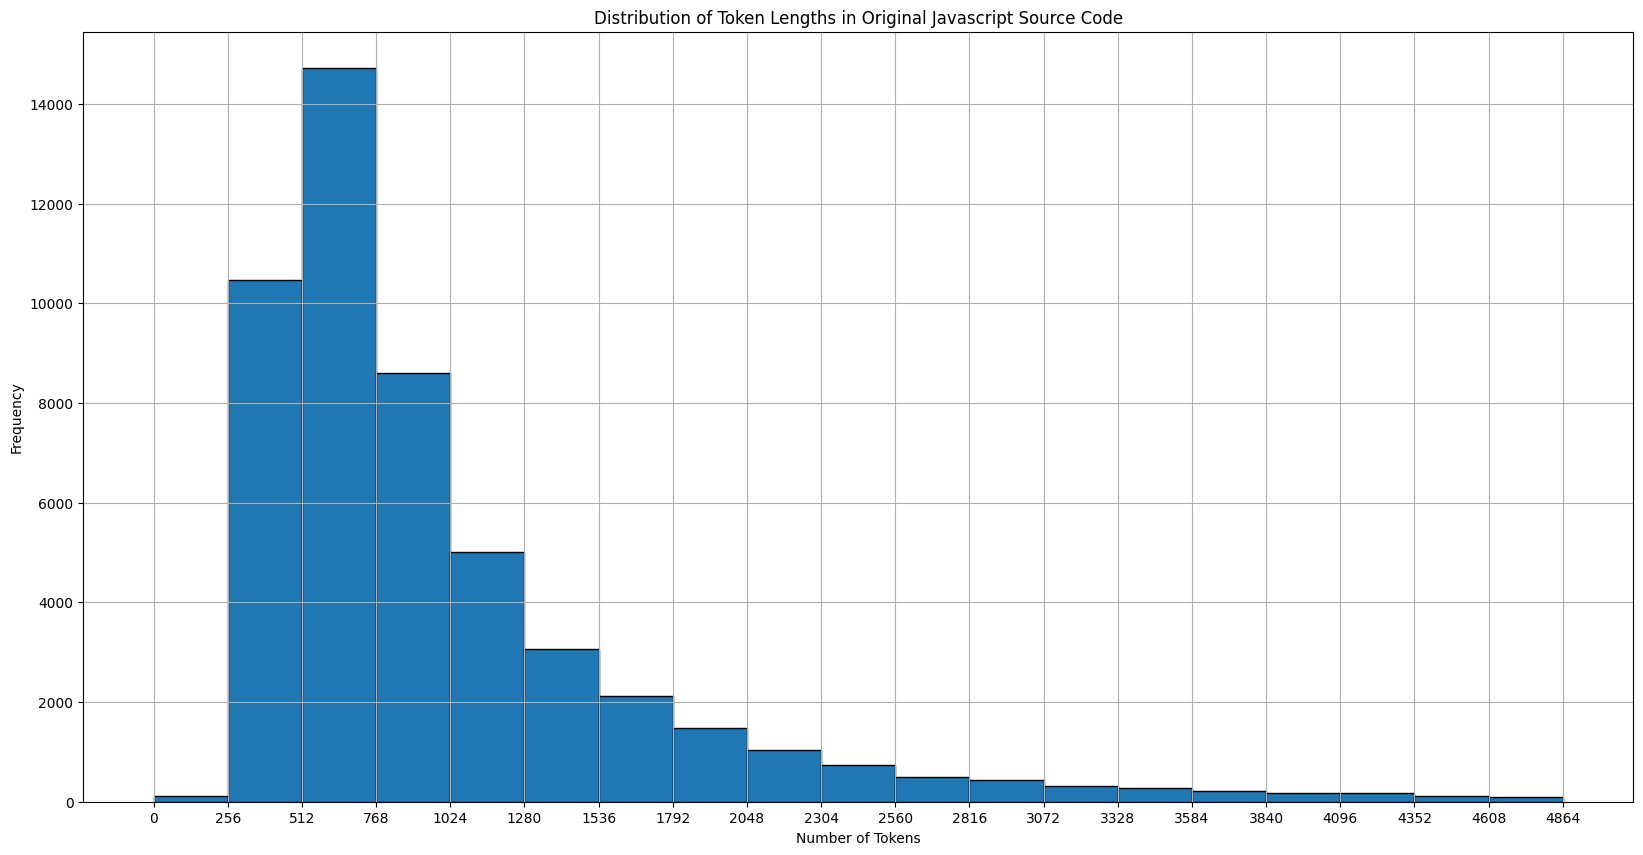

In [2]:
# STEP1 :Visualize the distribution of token counts for the original JavaScript code samples
distribution = df['js_original.token_count'].describe()
bins = np.arange(0, 5000, 256)
plt.figure(figsize=(20, 10))
plt.hist(df['js_original.token_count'], bins=bins, edgecolor='black')
plt.title('Distribution of Token Lengths in Original Javascript Source Code')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(True)
plt.show()

#STEP 2: BERT Training

In [7]:
# STEP 2 : Single-BERT classification (A100-optimized)

'''
The following optimizations were applied to the standard BERT training pipeline to maximize efficiency on the A100 GPU.
One can observe a huge improvement in accuracy with this setup when running on Google Colab's A100 instance.

  a. bf16: Uses 16-bit math instead of full 32-bit. Same accuracy in practice, but faster and uses less GPU memory.
  b. Dynamic padding: Instead of always padding to 512 tokens, pads only to the longest sequence in a batch. Cuts waste, speeds things up.
  c. Fused AdamW: Optimizer with CUDA-fused kernels — same math as normal AdamW but runs faster and with less overhead.
  d. TF32: Special Ampere hardware math mode that keeps 32-bit range but uses 10-bit mantissa. Almost same accuracy as FP32, but much faster on matrix multiplies.
'''

#----CONFIGURATIONS-------------

MODEL='bert-base-cased' # Choose a model to use. This is BERT base. You can switch to CodeBERT or any other model by providing the corresponding Hugging Face model name (e.g., microsoft/codebert-base)
TARGET_MODELS = ["gpt-4o", "gpt-4o-mini" ,"gpt-5-mini", "gpt-5-nano", "gpt-oss-120b"] # These are the models we aim to distinguish. In this setup, the task is a 5-class classification problem, restricted to GPT-family models only.
INPUT_FEATURE ='js_original.js_code'   # The input feature, whihc we teain our BERt model. You can choose:  js_original.js_code, rjsmin_simplified.js_code, js_obfuscated.js_code, terser_mangled.js_code, js_deobfuscated.js_code, etc...
#----CONFIGURATIONS-------------



filtered_df = df[df['model_name'].isin(TARGET_MODELS)].copy()
encoder = LabelEncoder()
filtered_df['model_class'] = encoder.fit_transform(filtered_df['model_name'])
num_labels = len(encoder.classes_)
print("Number of labels:", num_labels)
id2label = {i: lbl for i, lbl in enumerate(encoder.classes_)}
label2id = {lbl: i for i, lbl in enumerate(encoder.classes_)}
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

#Split the training and test frames so that there is no overlap between them, ensuring unbiased evaluation.
def get_dataframes(df, *, sample_size=None, test_size=0, val_size=0, random_state=42):
    groups = df["prompt"].unique()

    current_df = df

    if sample_size is not None and sample_size < len(df):
        avg_rows_per_group = len(df) / len(groups)
        n_groups_needed = int(sample_size / avg_rows_per_group)

        if n_groups_needed < len(groups):
            rng = np.random.RandomState(random_state)
            selected_groups = rng.choice(groups, size=n_groups_needed, replace=False)

            current_df = df[df["prompt"].isin(selected_groups)].copy()
        else:
            print(f"WARNING: The size of the Dataframe ({sample_size}) is smaller than the sample size ({len(df)})")

    if test_size > 0:
        splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_val_idx, test_idx = next(splitter.split(current_df, groups=current_df["prompt"]))

        train_val_df = current_df.iloc[train_val_idx]
        test_df = current_df.iloc[test_idx].copy()
    else:
        train_val_df = current_df
        test_df = pd.DataFrame(columns=df.columns)

    if val_size > 0:
        relative_val_size = val_size / (1 - test_size)
        if relative_val_size >= 1.0:
             raise ValueError("ERROR: The sum of test and val size reaches or exceeds 1.0!")

        splitter = GroupShuffleSplit(n_splits=1, test_size=relative_val_size, random_state=random_state)
        train_idx, val_idx = next(splitter.split(train_val_df, groups=train_val_df["prompt"]))

        train_df = train_val_df.iloc[train_idx].copy()
        val_df = train_val_df.iloc[val_idx].copy()
    else:
        train_df = train_val_df.copy()
        val_df = pd.DataFrame(columns=df.columns)

    return train_df, val_df, test_df


train_df, val_df, test_df = get_dataframes(filtered_df, val_size=0.1, test_size=0.1)


class StylometryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.df = dataframe.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        js_code = str(row[INPUT_FEATURE])
        text = f"{js_code}"
        enc = self.tok(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "token_type_ids": enc.get("token_type_ids", [0]*len(enc["input_ids"])),
            "labels": int(row["model_class"]),
        }

train_dataset = StylometryDataset(train_df, tokenizer)
val_dataset   = StylometryDataset(val_df, tokenizer)
test_dataset  = StylometryDataset(test_df, tokenizer)

# Dynamic padding (pads to longest in the batch; pad_to_multiple_of=8 helps Tensor Cores)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", pad_to_multiple_of=8)

# ---------------------------
# Metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r}



model = AutoModelForSequenceClassification.from_pretrained(MODEL,num_labels=num_labels,id2label=id2label,label2id=label2id,attn_implementation="sdpa",)



# ---------------------------
# Training parameters
# ---------------------------
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,      # eval can be large; reduce if you OOM at eval
    gradient_accumulation_steps=4,
    eval_accumulation_steps=16,         # stream logits to avoid eval spikes
    bf16=True, fp16=False,              # A100-friendly
    optim="adamw_torch_fused",
    learning_rate=2e-5,
    warmup_ratio=0.06,
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    label_smoothing_factor=0.05,
    max_grad_norm=1.0,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
)

# ---------------------------
# Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,     # << dynamic padding
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


Number of labels: 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.434700,1.063209,0.574694,0.545036,0.566566,0.574694
2,0.726200,0.688295,0.775510,0.771206,0.788313,0.775510
3,0.584100,0.669431,0.800000,0.795632,0.824095,0.800000
4,0.465300,0.635665,0.827755,0.825487,0.848881,0.827755
5,0.422800,0.543970,0.854694,0.854954,0.861359,0.854694
6,0.356000,0.522170,0.871837,0.872145,0.877190,0.871837
7,0.337800,0.534402,0.875102,0.875527,0.879867,0.875102
8,0.295600,0.549778,0.878367,0.878156,0.885652,0.878367
9,0.280700,0.545901,0.875918,0.875840,0.881934,0.875918
10,0.275700,0.540162,0.878367,0.878265,0.884378,0.878367


{'eval_loss': 0.5497779250144958,
 'eval_accuracy': 0.8783673469387755,
 'eval_f1': 0.8781564189457745,
 'eval_precision': 0.8856519065374425,
 'eval_recall': 0.8783673469387755,
 'eval_runtime': 3.7703,
 'eval_samples_per_second': 324.91,
 'eval_steps_per_second': 5.305,
 'epoch': 10.0}

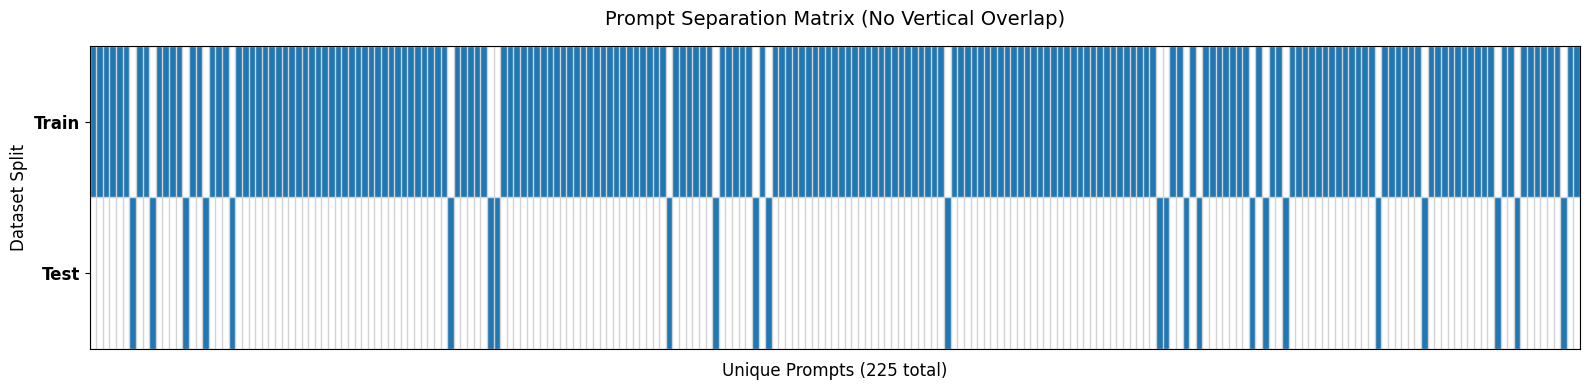

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
data = []

for p in train_df['prompt'].unique():
    data.append({'prompt': p, 'Split': 'Train'})



for p in test_df['prompt'].unique():
    data.append({'prompt': p, 'Split': 'Test'})

vis_df = pd.DataFrame(data)

all_prompts = sorted(vis_df['prompt'].unique())
splits = ['Train', 'Test']

matrix = np.zeros((len(splits), len(all_prompts)))

for i, split_name in enumerate(splits):
    prompts_in_split = set(vis_df[vis_df['Split'] == split_name]['prompt'])

    for j, prompt in enumerate(all_prompts):
        if prompt in prompts_in_split:
            matrix[i, j] = 1

fig, ax = plt.subplots(figsize=(16, 4))

cmap = mcolors.ListedColormap(['white', '#1f77b4'])

ax.imshow(matrix, cmap=cmap, aspect='auto', interpolation='nearest')

ax.set_yticks(np.arange(len(splits)))
ax.set_yticklabels(splits, fontsize=12, fontweight='bold')

if len(all_prompts) <= 50:
    ax.set_xticks(np.arange(len(all_prompts)))
    ax.set_xticklabels(all_prompts, rotation=90, fontsize=8)
else:
    ax.set_xticks([])
    ax.set_xlabel(f"Unique Prompts ({len(all_prompts)} total)", fontsize=12)

ax.set_xticks(np.arange(matrix.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(matrix.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="lightgray", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_title('Prompt Separation Matrix (No Vertical Overlap)', fontsize=14, pad=15)
ax.set_ylabel('Dataset Split', fontsize=12)

plt.tight_layout()
plt.show()


#STEP 3: Confusion Matrix of the Trained model

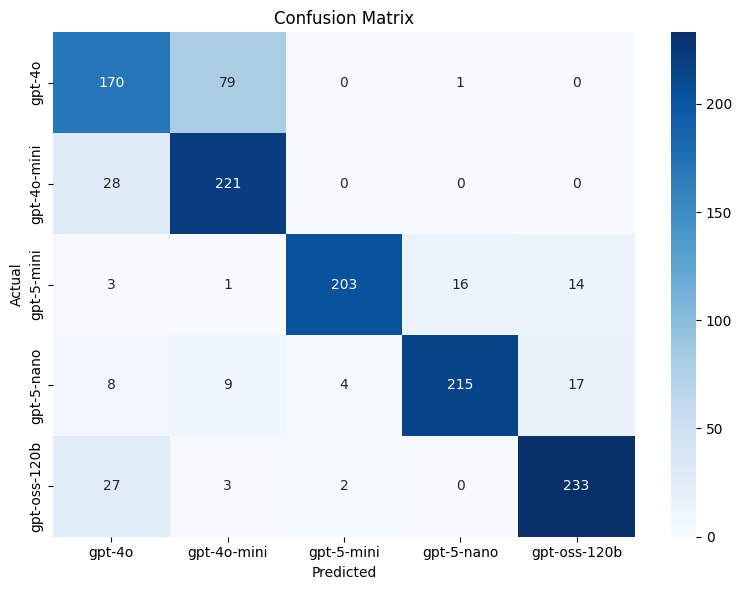

In [10]:
#Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)

# Extract predicted labels
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Get class names from the LabelEncoder
encoder = LabelEncoder()
encoder.fit(filtered_df['model_name'])  # or use the original encoder if stored

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()


#STEP 4: Save the model for later inference

In [11]:
import os, json

model_path = "BERT-model"
os.makedirs(model_path, exist_ok=True)

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Save label names in the exact order used by LabelEncoder
with open(os.path.join(model_path, "label_classes.json"), "w") as f:
    json.dump(list(encoder.classes_), f)


#STEP 5: Evaluate the BERT model on completely unseen dataset (the CROSSCHECK-V2.json dataset).

[*] Downloading the validation dataset...
Rows: 500
Using rows: 500
Prompt overlap with train: 0
Accuracy: 0.866
F1: 0.8650171652341757 Precision: 0.8746846529124787 Recall: 0.866

Per-class accuracy:
model_name
gpt-oss-120b    0.95
gpt-4o-mini     0.91
gpt-5-nano      0.89
gpt-4o          0.85
gpt-5-mini      0.73
Name: correct, dtype: float64

Confusion matrix (rows=true, cols=pred):
              gpt-4o  gpt-4o-mini  gpt-5-mini  gpt-5-nano  gpt-oss-120b
gpt-4o            85           15           0           0             0
gpt-4o-mini        8           91           0           1             0
gpt-5-mini         1            0          73          15            11
gpt-5-nano         2            1           0          89             8
gpt-oss-120b       4            0           0           1            95


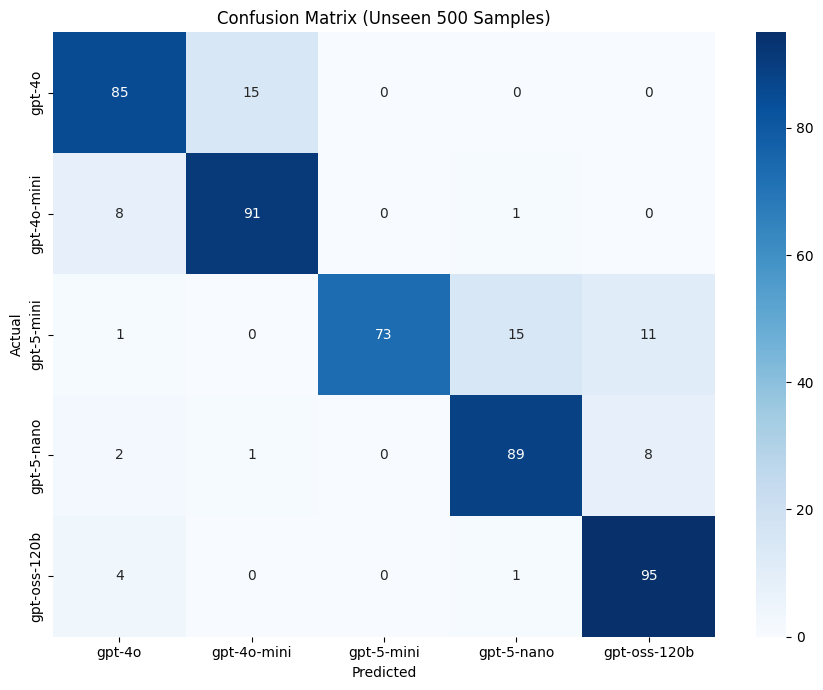

In [12]:
import os, json, torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "BERT-model"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()

# Load label mapping (must exist)
with open(os.path.join(model_path, "label_classes.json"), "r") as f:
    classes = json.load(f)  # list of model_name strings in correct id order

label2id = {name: i for i, name in enumerate(classes)}
id2label = {i: name for i, name in enumerate(classes)}

print("[*] Downloading the validation dataset...")
!wget -O CROSSCHECK.json https://github.com/LLM-NodeJS-dataset/LLM-NodeJS-dataset/raw/refs/heads/main/500_validation_dataset.json > /dev/null 2>&1

UNSEEN_PATH = "/content/CROSSCHECK.json"

with open(UNSEEN_PATH, "r", encoding="utf-8") as f:
    unseen = json.load(f)

unseen_df = pd.json_normalize(unseen, sep=".")
print("Rows:", len(unseen_df))
unseen_df = unseen_df[unseen_df["model_name"].isin(TARGET_MODELS)].copy()

# If you want exactly 500 and the file contains more:
unseen_df = unseen_df.sample(n=min(500, len(unseen_df)), random_state=42).reset_index(drop=True)
print("Using rows:", len(unseen_df))

#Run evaluation on the dataset
CODE_COL = INPUT_FEATURE
texts = ("code: " + unseen_df[CODE_COL].astype(str)).tolist()
MAX_LEN = 512
BATCH = 64

# Ground-truth labels (must match training label2id)
y_true = unseen_df["model_name"].map(label2id).to_numpy()
if np.any(pd.isna(unseen_df["model_name"].map(label2id))):
    missing = sorted(set(unseen_df["model_name"]) - set(label2id.keys()))
    raise ValueError(f"Found labels not in saved label mapping: {missing}")

y_pred = []

with torch.no_grad():
    for i in range(0, len(texts), BATCH):
        batch_texts = texts[i:i+BATCH]
        enc = tokenizer(
            batch_texts,
            truncation=True,
            max_length=MAX_LEN,
            padding=True,              # ok for inference batching
            return_tensors="pt",
        ).to(device)

        logits = model(**enc).logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        y_pred.extend(preds)

y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
train_prompts = set(train_df["prompt"])  # only if train_df still exists in your runtime
unseen_prompts = set(unseen_df["prompt"])
print("Prompt overlap with train:", len(train_prompts & unseen_prompts))

print("Accuracy:", acc)
print("F1:", f1, "Precision:", p, "Recall:", r)
# Per-class accuracy
unseen_df["y_true"] = y_true
unseen_df["y_pred"] = y_pred
unseen_df["pred_model"] = unseen_df["y_pred"].map(id2label)

per_class = (
    unseen_df.assign(correct=(unseen_df["y_true"] == unseen_df["y_pred"]))
             .groupby("model_name")["correct"]
             .mean()
             .sort_values(ascending=False)
)
print("\nPer-class accuracy:")
print(per_class)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm_df)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
conf_matrix = confusion_matrix(
    y_true,
    y_pred,
    labels=list(range(len(classes)))
)

# Plot
plt.figure(figsize=(9, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Unseen 500 Samples)")
plt.tight_layout()

# Save to file
plt.savefig("confusion_matrix_unseen.pdf")
plt.savefig("confusion_matrix_unseen.png", dpi=300)

plt.show()

